In [1]:
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet
!pip install jsonlines --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.2 MB/s eta 0:00:00


In [2]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/...
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
! apt install cm-super

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [979 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [833 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [43.3 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [456 kB]
Hit:13 https://ppa.

In [3]:
from transformers import (
    BertTokenizer,
    BertModel,
    TFBertModel,
    BertConfig,
    AutoTokenizer,
    AutoModel,
)

In [4]:
import pandas as pd
import numpy as np
import random
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

In [14]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
GNE_PATH = '/content/drive/MyDrive/w266_final_project/data/GoodNewsEveryone'

In [7]:
EMOCAUSE_PATH = '/content/drive/MyDrive/w266_final_project/data/EmoCause'

In [8]:
DATA_PATH_LOCAL = './data/GoodNewsEveryone'

In [9]:
cause_model_name = 'mrm8488/spanbert-finetuned-squadv2'

spanbert_tokenizer = BertTokenizer.from_pretrained(cause_model_name)
spanbert_model = TFBertModel.from_pretrained(cause_model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
gne_train_preprocessed = pd.read_csv(f'{GNE_PATH}/gne_train_preprocessed.csv')
gne_test_preprocessed = pd.read_csv(f'{GNE_PATH}/gne_test_preprocessed.csv')

In [10]:
emocause_train_preprocessed = pd.read_csv(f'{EMOCAUSE_PATH}/emocause_train_preprocessed.csv')
emocause_test_preprocessed = pd.read_csv(f'{EMOCAUSE_PATH}/emocause_test_preprocessed.csv')

In [22]:
gne_headline_lengths = [spanbert_tokenizer(list(gne_train_preprocessed.headline)[i],
                                           padding=True,
                                           return_tensors='tf').input_ids.numpy().shape[1] - 2 for i in range(len(gne_train_preprocessed))]

In [19]:
emocause_sit_lengths = [spanbert_tokenizer(list(emocause_train_preprocessed.original_situation)[i],
                                           padding=True,
                                           return_tensors='tf').input_ids.numpy().shape[1] - 2 for i in range(len(emocause_train_preprocessed))]

In [23]:
gne_span_lengths = list(gne_train_preprocessed.end_index - gne_train_preprocessed.start_index + 1)
gne_span_perc = [gne_span_lengths[i] / gne_headline_lengths[i] for i in range(len(gne_span_lengths))]

In [24]:
emocause_span_lengths = list(emocause_train_preprocessed.end_index - emocause_train_preprocessed.start_index + 1)
emocause_span_perc = [emocause_span_lengths[i] / emocause_sit_lengths[i] for i in range(len(emocause_span_lengths))]

In [11]:
emocause_t_sit_lengths = [spanbert_tokenizer(list(emocause_test_preprocessed.original_situation)[i],
                                                padding=True,
                                                return_tensors='tf').input_ids.numpy().shape[1] - 2 for i in range(len(emocause_test_preprocessed))]

In [12]:
emocause_t_span_lengths = list(emocause_test_preprocessed.end_index - emocause_test_preprocessed.start_index + 1)
emocause_t_span_perc = [emocause_t_span_lengths[i] / emocause_t_sit_lengths[i] for i in range(len(emocause_t_span_lengths))]

In [ ]:
fig, axs = plt.subplots(2)

fig.set_figheight(8)

axs[0].hist(gne_span_perc, bins=20, edgecolor='black', color = 'gray')
axs[0].set_title('GNE')
axs[0].axvline(sum(gne_span_perc) / len(gne_span_perc), color='k', linestyle='dashed', linewidth=1)
for item in ([axs[0].title, axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontsize(16)

fig.subplots_adjust(hspace=.3)

axs[1].hist(emocause_span_perc, bins=20, edgecolor='black', color = 'gray')
axs[1].set_title('EmoCause')
axs[1].axvline(sum(emocause_span_perc) / len(emocause_span_perc), color='k', linestyle='dashed', linewidth=1)
for item in ([axs[1].title, axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(16)

fig.savefig(f'{GNE_PATH}/histograms_span_perc.pgf')

In [16]:
fig, axs = plt.subplots()

axs.hist(emocause_t_span_perc, bins=20, edgecolor='black', color = 'gray')
axs.set_title('EmoCause')
axs.axvline(sum(emocause_t_span_perc) / len(emocause_t_span_perc), color='k', linestyle='dashed', linewidth=1)
for item in ([axs.title, axs.xaxis.label, axs.yaxis.label] +
             axs.get_xticklabels() + axs.get_yticklabels()):
    item.set_fontsize(16)

fig.savefig(f'{GNE_PATH}/histograms_span_test_perc.pgf')

In [ ]:
gne_e2_test_preds = [ 4, 10,  2,  0,  7, 14, 10,  0, 10,  9,  9, 10,  8,  9,  3,  0,  5,
       10,  8, 10, 10,  9, 10, 10,  8,  7,  7,  8,  1,  8,  2, 10, 12,  2,
        7,  7,  0,  8,  1,  7,  5,  3,  8,  7,  7,  7,  7,  5, 10,  0, 12,
        7,  9,  8,  1, 10,  8,  0,  3,  2,  9,  1,  8,  9,  7,  2, 13,  3,
        7,  3, 11,  1, 10,  7,  3, 10,  2, 12,  1,  7,  7,  8,  8,  1,  9,
        9,  3,  2,  3,  2,  0,  9,  7, 10, 10,  3,  9,  2,  8,  7,  7,  7,
        0,  4,  3,  2,  7,  8,  5,  9,  1,  9,  4,  8,  9,  3,  3,  0,  9,
        7,  9,  2,  8, 12,  9,  8,  2, 10,  7,  3,  7,  5,  2,  8,  3, 10,
        7,  0,  2,  3, 12, 10,  5,  2,  7,  3,  1,  7,  7,  9,  7,  2,  9,
        8,  4,  8,  1, 12,  2,  3,  2,  7,  3,  7,  8,  9, 14,  4,  3,  2,
       12,  7,  3,  0,  3,  1,  4,  2,  2,  7,  4,  9,  0,  1,  8,  4,  8,
       10,  9,  8,  1,  2,  2,  1,  4,  9,  3,  5,  4,  8,  9,  5,  8,  8,
        4,  4,  8,  9,  9,  8,  0,  0,  7,  7, 10,  1, 10, 12,  3,  7, 10,
        1,  4,  2,  7,  7,  8, 10,  8,  5,  7,  8,  8,  3,  3,  1,  2,  7,
        3,  4, 10,  8,  7, 14,  1,  8, 12, 12,  7,  9,  7,  9,  4,  9, 12,
       13, 13,  8,  7,  0, 10,  9, 10,  8,  0,  7,  8,  5,  9,  9,  1,  7,
        9,  8,  1,  0,  2,  8,  7,  8,  8,  3,  9,  9,  7,  7, 12,  5,  3,
        0,  9,  5,  3,  7, 10,  3, 10,  4,  8,  7,  7, 12,  9, 10,  8,  3,
       10,  9, 11,  8,  9,  1,  3,  5, 10,  9,  7,  0,  3,  0,  3, 10,  0,
        7, 10,  4,  9, 13,  9,  1,  3, 10,  4, 11,  7,  4,  7,  1,  7,  9,
        1,  9, 10, 10,  9,  4, 10,  8,  2,  8,  3,  9,  5,  1,  3,  7,  3,
        3,  3,  4,  1,  8,  3,  7,  0,  2,  5,  2,  1,  8,  7,  7,  7,  1,
        0,  7,  9,  3,  4,  1,  9, 10,  3,  5,  2,  3,  8,  9,  5,  0, 10,
        7, 10, 10, 10, 10,  9, 12,  7,  7, 12,  8,  7,  9, 10,  3,  9,  7,
        8, 10,  9,  8,  3,  2,  7,  7,  2,  9,  4,  8,  1, 14,  9, 10,  7,
        9, 12, 10,  9,  4,  3,  4, 10,  9,  9,  9,  8,  8, 10,  4,  8,  3,
       10, 10,  7,  3, 10,  7,  0,  1,  3,  4,  8,  7,  4,  1, 10,  7,  8,
       10,  8,  1, 12, 14,  7,  3, 10,  2,  7, 14,  3,  8,  8, 10,  7,  9,
        8,  8,  9,  9,  3,  8, 10, 12,  9,  7,  4,  1, 12, 14,  9,  8, 10,
        3,  8,  3,  8,  1,  7,  1, 10,  7,  4,  9,  7,  1,  3,  0, 10,  3,
        0,  7,  7, 10,  0,  9,  7,  1, 10,  0,  4,  7, 10, 12,  1,  5,  3,
        3,  0,  8,  8,  1,  5,  7,  9,  3,  8,  7,  4,  0,  9,  0, 10,  8,
        0,  0,  3,  2, 10,  7, 12,  0,  1,  2,  7,  8,  0,  8,  7,  3,  7,
       10,  3, 12,  2, 10,  9,  3,  7,  2,  9,  8,  1,  7,  8,  8,  9,  9,
        5,  8,  5,  0,  2,  7,  1,  5,  8,  3,  8, 10,  5, 10,  3,  7,  7,
        4,  9,  9,  1,  5,  2,  4, 10,  7,  0,  3, 10,  1, 10,  1, 10,  9,
        8,  2,  2,  4,  7,  7,  2,  7, 12,  8,  2, 14, 12,  0, 10,  8,  1,
        1, 11,  8,  8,  3,  8,  4, 10,  0, 10,  8, 10,  8, 12,  3,  9,  9,
        4,  2,  4,  3,  2,  3,  2, 10,  8,  9,  9,  8,  9,  0, 10,  8,  3,
        8,  7,  7,  0,  0,  8,  9,  7,  8,  3,  8,  3,  0, 10,  3, 10,  9,
       10,  2,  4, 10,  7,  8,  1,  1,  7,  7, 10,  8,  7,  9,  9,  8,  2,
        7,  3,  2, 12,  1,  2,  3,  4, 10,  1,  3,  2,  4,  4,  3,  2,  7,
       10,  2,  3,  8,  1,  9,  1,  4,  7, 10,  7,  2,  3, 10,  7,  7,  2,
        5, 10,  2, 12,  3, 13,  4, 12,  1,  0,  2,  8, 10,  7,  0,  2,  4,
        3,  9, 10,  1,  9,  3,  3, 14, 12, 13,  8,  8,  7,  7, 10,  8,  8,
        8,  9,  9, 12,  7,  0,  4, 12,  8,  8,  1, 12,  3,  3,  7, 12, 12,
        3,  5,  7,  7,  1, 10,  0,  0,  7,  3,  9,  4,  0,  1,  4,  9,  5,
        3, 10, 14, 14,  3,  8,  0,  7,  9,  3,  0,  7,  4,  3, 12,  9, 10,
        4,  0,  4,  7,  3,  9, 13,  2, 12, 11,  0,  8,  3,  3, 10,  9,  7,
        2,  9,  9,  1,  9,  7, 13,  8,  7,  8,  8, 10,  9, 10, 12, 10,  1,
        7,  0,  1,  0, 12,  1,  3,  5, 13,  4, 14, 12,  9,  9,  9, 10,  8,
        7,  4,  9,  2,  9,  9,  5,  7,  2,  1,  0,  7,  7,  7,  9,  1,  8,
        3,  7,  3,  7,  0,  1,  4,  1,  2,  7,  7,  9,  7,  8,  0,  3,  3,
       12,  8, 10,  8,  9,  3,  7,  7,  9, 10,  0,  7,  4,  3,  9,  4,  9,
        0,  7,  0,  3,  8,  2,  4,  9,  9,  7, 10,  9,  1,  8,  3,  4,  4,
        3,  8,  4,  7, 12,  0,  9,  4,  3, 10, 10,  3,  9, 12, 10,  8,  7,
        0,  7, 10,  9,  7, 12,  3,  8]

In [ ]:
emocause_test_preds = [21, 30, 13,  0, 18, 26, 28, 16, 25,  8, 19,  3,  1, 28,  8,  4,  7,
       19,  4, 27,  3, 27,  2, 12, 25,  9, 29,  3,  1,  5, 26, 15, 12, 31,
       29,  4, 20, 13, 22,  7,  0, 13,  9, 14, 10,  0, 14, 21, 18, 10,  9,
       28, 18,  6, 27, 15, 17, 22, 22,  7,  3, 13,  9, 28, 15, 26,  5,  3,
       31, 24, 21, 29, 10, 19, 17, 13, 31, 29, 13,  7,  2,  7, 14,  5, 23,
       10,  1,  0, 24,  2,  7, 18, 29, 13, 18, 25, 19,  2,  0, 16, 18, 12,
       14, 12, 22, 22, 18, 21, 23,  2, 21, 14, 12, 13, 14, 30,  2, 12, 30,
       18, 24, 10, 28, 11,  3, 29, 11, 24, 29,  1, 23, 29, 31, 14,  4, 13,
       29, 29, 25,  8, 28, 14,  8, 22,  6,  5, 26,  5, 14, 12, 31,  0,  5,
       27, 15,  0, 10, 22, 12, 29, 26,  2, 22,  3,  6, 29, 21,  9, 14, 10,
       13, 21,  2,  9, 21, 11, 17, 29,  8, 17, 27, 24,  9, 27,  2, 18, 18,
       29, 11, 23,  3,  2, 14,  6, 17,  3, 14, 25, 21, 20, 29, 29,  1, 24,
       20, 19, 14, 21,  2,  3, 22, 14,  6,  8, 27,  8, 27, 24,  0, 19,  1,
        1,  1, 21, 26, 21,  3, 24,  4, 27, 19, 22, 30,  0, 22, 18, 11, 28,
       11,  4, 14, 31, 12,  3, 30, 15,  6,  7, 12, 22,  4, 29, 27, 19, 30,
       22, 29,  2,  2, 16, 26,  8, 13,  5, 25, 27, 29,  2, 14, 24,  4, 12,
       15,  1,  6,  2, 22, 17, 26, 26,  3, 20, 19, 10,  9, 22,  2, 25, 22,
       10,  4, 28,  1, 22, 29,  2, 19,  3, 19, 24, 28, 28,  4, 26, 10, 22,
       21, 22,  9, 23, 22, 28, 29, 24, 22, 14, 28,  1,  0,  1, 22,  7,  7,
        7,  0, 27,  4, 14, 23, 18, 20,  4, 10,  6, 14, 31, 23,  9, 11, 12,
       10, 26, 26, 10, 29, 10,  2, 22,  0,  4,  0, 26,  2, 25,  0, 11, 20,
       24,  8, 19, 25, 20, 22, 30, 12,  8,  2, 14, 30, 10,  0, 11, 15, 22,
       20,  4, 24, 23, 16, 28, 31,  0, 30, 13, 20, 11, 13, 26,  8, 14, 19,
       29, 20, 19,  2,  1, 29, 21,  2, 16, 22, 22, 27, 28, 14,  5,  7, 22,
       20,  2, 13, 14,  9, 31, 16,  5, 20, 21,  0, 20,  0, 13, 30,  7,  2,
       23, 15, 16, 21, 27, 27, 29,  0,  4,  2, 22, 26, 19, 15, 29,  3, 26,
       19, 10,  4, 16, 12, 14, 13,  7, 17, 13, 24, 10,  0, 14,  1, 13,  1,
       17,  0, 11, 20,  9,  1,  7, 10,  8, 26, 10, 17, 30,  5, 23,  2, 17,
       19, 15, 26, 27, 21,  4, 10, 24,  1, 18,  2, 12,  2, 15, 18, 11, 13,
       29,  7, 13, 24, 12, 22, 23,  9, 22, 21,  8, 22, 24,  7, 19, 26, 11,
       30,  8, 17,  7, 25,  0,  2, 11, 17, 20, 26, 29,  7, 21,  2, 22, 26,
        4, 25, 14, 16, 10,  7, 22, 14, 28, 11, 29, 24,  7,  0, 21, 29,  0,
       20, 12, 11,  7, 13, 14, 16, 10, 20, 21, 24, 26, 19, 28, 24,  8, 27,
       29, 10,  7, 20,  2, 27, 23, 14, 22, 12, 21, 14, 20, 22, 10,  0, 29,
        2, 19,  7,  7, 27, 26, 10,  2, 27,  3, 23, 17,  8, 13,  2, 21, 29,
       26, 20, 30, 27, 28,  6,  9, 21,  2, 22, 14, 14, 14, 11,  9, 22,  3,
        9, 14, 11,  1, 10, 10,  4, 24, 14,  9, 22, 18, 13, 17,  4, 10, 24,
       29, 18,  2,  2,  6, 15,  4, 24,  0, 20,  4, 24,  2, 29,  0, 16, 30,
       22, 27, 29, 12, 27,  7, 11, 26, 22, 11, 25,  3, 16,  7,  9,  9, 24,
        1, 30, 28, 23,  2,  6, 20,  3, 21,  2,  8, 29,  9, 12, 29, 21, 31,
        2, 11, 17, 26, 19, 29,  2,  3, 26,  0, 29,  4,  2, 13, 10, 16, 22,
        2, 11, 29, 14, 16, 29,  0,  2, 28, 26, 14, 14, 24, 23,  0,  2, 18,
       16, 24,  2, 14,  5, 31,  9,  8, 21, 17, 20, 16, 12, 23, 10, 24, 11,
       22,  6, 14, 23, 10, 30, 26,  7, 17, 24, 13,  8, 18, 24,  9,  9,  7,
       15, 14,  9, 22, 11, 21, 24, 22, 30, 19, 30,  7, 14, 11, 14, 12, 23,
        8,  0,  9,  2,  6, 15, 14, 11,  6, 23, 16, 20,  8, 12,  2,  2, 26,
       11, 15,  4, 14, 30,  3, 17,  3, 30,  2,  2, 23,  1, 11, 22, 15,  9,
       19,  2,  3, 23, 28, 15, 10, 14, 11,  3, 29, 16, 18, 29,  2, 29, 23,
       13, 20,  0, 27,  0, 24, 18, 29, 30,  7, 16, 13, 11, 13, 26, 27,  2,
       20, 29, 24, 13, 12]

In [ ]:
gne_target_names = list(np.unique(gne_train_preprocessed[['emotion_label', 'dominant_emotion']].sort_values(['emotion_label'])['dominant_emotion']))
emocause_target_names = list(np.unique(emocause_train_preprocessed[['emotion_label', 'emotion']].sort_values(['emotion_label'])['emotion']))

In [ ]:
gne_test_preprocessed.dominant_emotion.value_counts()

negative_surprise                            168
positive_surprise                            118
annoyance                                     84
disgust                                       82
fear                                          81
anger                                         80
positive_anticipation_including_optimism      71
sadness                                       66
negative_anticipation_including_pessimism     53
joy                                           49
guilt                                         33
shame                                         25
trust                                         25
love_including_like                           15
pride                                         10
Name: dominant_emotion, dtype: int64

In [ ]:
emocause_test_preprocessed.emotion.value_counts()

__surprised__       46
__grateful__        39
__proud__           36
__joyful__          34
__jealous__         33
__annoyed__         32
__embarrassed__     32
__guilty__          30
__excited__         30
__disappointed__    29
__sentimental__     29
__angry__           28
__caring__          27
__disgusted__       27
__hopeful__         26
__prepared__        25
__nostalgic__       24
__lonely__          24
__apprehensive__    24
__sad__             23
__devastated__      23
__impressed__       22
__ashamed__         22
__terrified__       22
__anxious__         22
__confident__       21
__anticipating__    20
__content__         20
__faithful__        19
__afraid__          17
__furious__         17
__trusting__        15
Name: emotion, dtype: int64

In [ ]:
gne_test_e_labels = list(gne_test_preprocessed.emotion_label)
emocause_test_e_labels = list(emocause_test_preprocessed.emotion_label)

In [ ]:
# Reorder confusion matrix by similar categories
order = np.array([1, 13, 4, 12, 0, 2, 3, 7, 8, 10, 9, 5, 11, 6, 14])
ordered_names = ['annoyance', 'shame', 'guilt', 'sadness', 'anger', 'disgust', 'fear', 'negative_anticipation',
                 'negative_surprise', 'positive_surprise', 'positive_anticipation', 'joy', 'pride', 'love_including_like', 'trust']

In [ ]:
cm = pd.crosstab(gne_test_e_labels, gne_e2_test_preds,
                 rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# Add back missing 0 column in cm, and reorder
cm[6] = 0
cm = cm[np.arange(15)]

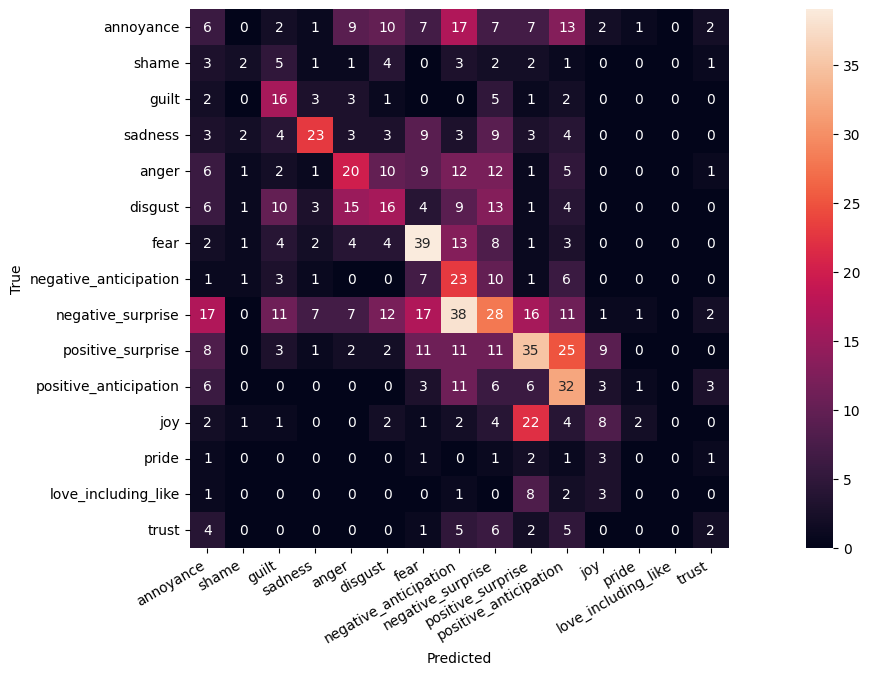

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm.iloc[order, order], annot=True,
    xticklabels=ordered_names,
    yticklabels=ordered_names)
plt.xlabel("Predicted")
plt.xticks(rotation=30, ha='right')
plt.ylabel("True")
plt.gca().set_aspect('equal')

In [ ]:
cm_e = pd.crosstab(emocause_test_e_labels, emocause_test_preds,
                   rownames=['Actual'], colnames=['Predicted'])

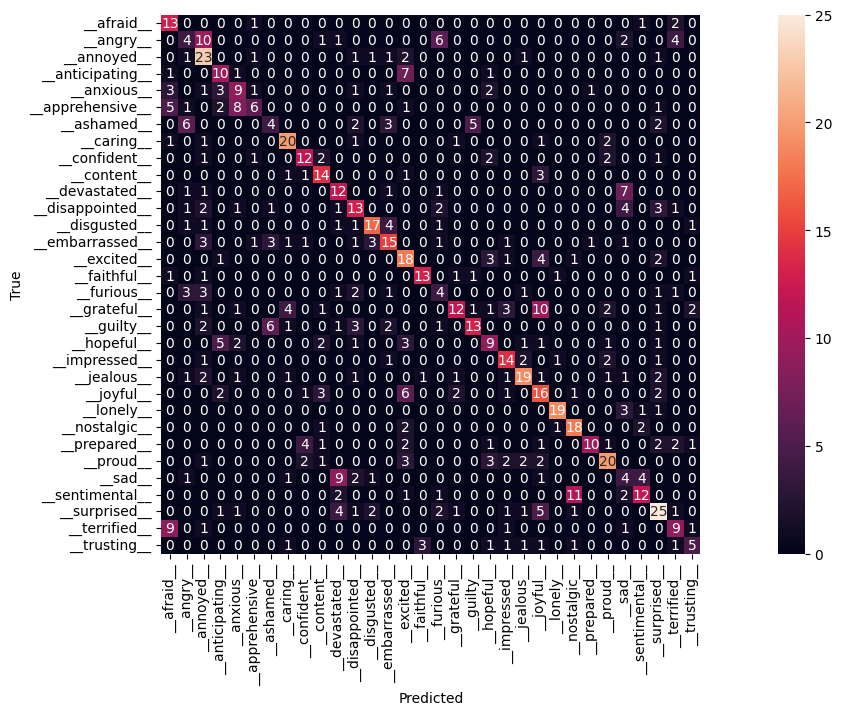

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm_e, annot=True,
    xticklabels=emocause_target_names,
    yticklabels=emocause_target_names)
plt.xlabel("Predicted")
plt.xticks(rotation=90)
plt.ylabel("True")
plt.gca().set_aspect('equal')